In [1]:

import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.18.0


In [8]:
# Create a list with the filepaths for training and testing
train_dir = Path(r'C:/Users/Dell/OneDrive/Desktop/Major -k/train')
train_filepaths = list(train_dir.rglob('**/*.jpg'))

In [9]:
test_dir = Path(r'C:/Users/Dell/OneDrive/Desktop/Major -k/test')
test_filepaths = list(test_dir.rglob('**/*.jpg'))

In [10]:
val_dir = Path(r'C:/Users/Dell/OneDrive/Desktop/Major -k/validation')
val_filepaths = list(val_dir.rglob('**/*.jpg'))

In [11]:

def image_processing(filepaths):
    """Create a DataFrame with the filepaths and the labels of the pictures."""
    
    # Extract labels from file paths
    labels = [Path(fp).parent.name for fp in filepaths]
    
    # Convert filepaths to a Series
    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    
    # Convert labels to a Series
    labels_series = pd.Series(labels, name='Label')
    
    # Concatenate Series into a DataFrame
    df = pd.concat([filepath_series, labels_series], axis=1)
    
    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


In [12]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [13]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['paprika' 'chilli pepper' 'cucumber' 'lettuce' 'carrot' 'lemon'
 'eggplant' 'cabbage' 'potato' 'jalepeno' 'capsicum' 'grapes' 'sweetcorn'
 'pineapple' 'spinach' 'sweetpotato' 'cauliflower' 'garlic' 'onion'
 'beetroot' 'raddish' 'mango' 'orange' 'soy beans' 'pomegranate' 'corn'
 'pear' 'kiwi' 'apple' 'tomato' 'banana' 'turnip' 'bell pepper' 'ginger'
 'peas' 'watermelon']


In [14]:
train_df.head(5)

,Filepath,Label
0,C:\Users\Dell\OneDrive\Desktop\Major -k\train\...,paprika
1,C:\Users\Dell\OneDrive\Desktop\Major -k\train\...,chilli pepper
2,C:\Users\Dell\OneDrive\Desktop\Major -k\train\...,cucumber
3,C:\Users\Dell\OneDrive\Desktop\Major -k\train\...,lettuce
4,C:\Users\Dell\OneDrive\Desktop\Major -k\train\...,carrot


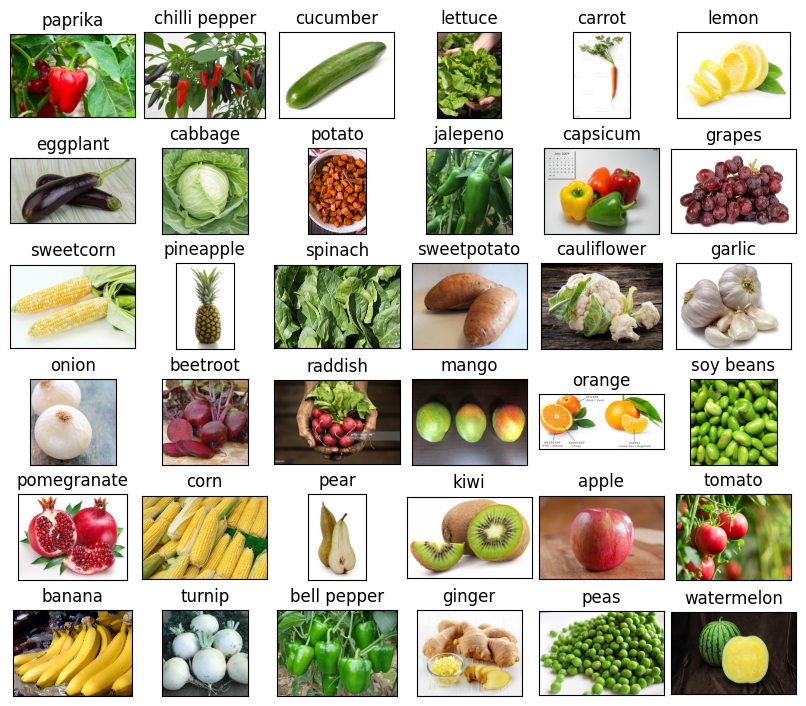

In [15]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [19]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [20]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 345 validated image filenames belonging to 37 classes.


In [21]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [22]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
) 

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.3633 - loss: 2.5296 - val_accuracy: 0.8647 - val_loss: 0.4987
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8098 - loss: 0.6164 - val_accuracy: 0.9147 - val_loss: 0.3104
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8794 - loss: 0.3638 - val_accuracy: 0.9118 - val_loss: 0.2638
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9162 - loss: 0.2477 - val_accuracy: 0.9382 - val_loss: 0.2135
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9531 - loss: 0.1537 - val_accuracy: 0.9676 - val_loss: 0.1842


In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


['mango',
 'ginger',
 'cauliflower',
 'ginger',
 'raddish',
 'jalepeno',
 'raddish',
 'peas',
 'orange',
 'peas',
 'spinach',
 'banana',
 'jalepeno',
 'turnip',
 'grapes',
 'watermelon',
 'bell pepper',
 'capsicum',
 'soy beans',
 'corn',
 'soy beans',
 'soy beans',
 'pomegranate',
 'apple',
 'eggplant',
 'orange',
 'sweetpotato',
 'cabbage',
 'pomegranate',
 'lemon',
 'peas',
 'garlic',
 'soy beans',
 'onion',
 'carrot',
 'jalepeno',
 'garlic',
 'paprika',
 'cauliflower',
 'eggplant',
 'eggplant',
 'pomegranate',
 'pomegranate',
 'sweetcorn',
 'mango',
 'pineapple',
 'grapes',
 'lettuce',
 'cauliflower',
 'capsicum',
 'cauliflower',
 'capsicum',
 'pear',
 'eggplant',
 'garlic',
 'pineapple',
 'lemon',
 'chilli pepper',
 'pear',
 'watermelon',
 'mango',
 'orange',
 'corn',
 'corn',
 'ginger',
 'raddish',
 'turnip',
 'kiwi',
 'cucumber',
 'carrot',
 'chilli pepper',
 'spinach',
 'corn',
 'eggplant',
 'apple',
 'lemon',
 'bell pepper',
 'banana',
 'sweetcorn',
 'carrot',
 'sweetpotato',


In [27]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [29]:
img = output('C:/Users/Dell/OneDrive/Desktop/Major -k/test/banana/Image_1.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'banana'

In [30]:
model.save('FV.h5')